In [10]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image
import torch 
import torch.nn as nn 
from torchvision import datasets, models, transforms
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader,Dataset,random_split
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingWarmRestarts
from models import Alex_Net,depthwise_separable_conv,MobileNet_Variant
from Chekpoint import Checkpoint
from torchsummary import summary 

In [2]:

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes = sorted(os.listdir(root))
        
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.load_images()

    def load_images(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root, class_name)
            class_idx = self.class_to_idx[class_name]
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                images.append((file_path, int(class_idx)))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path, label = self.images[index]
        img = Image.open(img_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

# Replace 'path/to/your/dataset' with the actual path to your dataset
dataset_path = r'C:\Users\Ali\Desktop\DL Papers\Face_Emotion\TRAIN'
x_translation = int(0.1 * 128)
y_translation = int(0.1 * 128)
# Define the data transformations

transform = transforms.Compose([
    
    transforms.RandomHorizontalFlip(p=.5),
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create CustomDataset
custom_dataset = CustomDataset(root=dataset_path, transform=transform)
validation_size = int(len(custom_dataset) * 0.2)
train_dataset, val_dataset = random_split(custom_dataset, [len(custom_dataset) - validation_size, validation_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)     

  

    

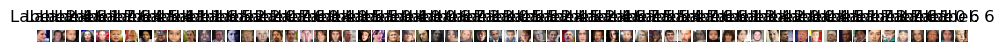

In [4]:
data,label = next(iter(valid_loader))

def show_images(images, labels):
    plt.figure(figsize=(12, 6))
    for i in range(images.size(0)):
        plt.subplot(1, 64, i + 1)
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        plt.imshow(img)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Display the batch of images
show_images(data, label) 

In [5]:
def fit(clf,
        train_loader,
        optimizer,
        criterian,
        scheduler):

    clf.train()
    training_loss_running = 0
    training_correct_running = 0
    total = 0
    counter = 0
    for i,data in enumerate(train_loader):
        counter += 1
        data,label = data[0],data[1]
        #data = data.reshape(-1,28*28)
        total += label.size(0)
        optimizer.zero_grad()
        out = clf(data)
        loss = criterian(out,label)
        training_loss_running += loss.item()
        _,pred = torch.max(out.data,1)
        training_correct_running += (pred == label).sum().item()
        loss.backward()
        optimizer.step()
    scheduler.step() 
    train_loss = training_loss_running / counter
    train_accuracy = 100. * training_correct_running / total
    return train_loss, train_accuracy     


In [16]:
def validation (clf,validation_loader,criterian,epoch):
    clf.eval()
    valid_loss_running = 0
    valid_acc_running = 0
    total = 0
    counter = 0
    for i,data in enumerate(validation_loader):
        counter += 1
        data,label = data[0],data[1]
        #data = data.reshape(-1,28*28)
        total += label.size(0)
        out = clf(data)
        loss = criterian(out,label)
        valid_loss_running += loss.item()
        _,pred = torch.max(out.data,1)
        valid_acc_running += (pred == label).sum().item()

    valid_loss = valid_loss_running / counter
    valid_acc = 100. * valid_acc_running / total  
    chk.save(valid_acc,'chk',epoch,clf)
      

    return valid_loss,valid_acc


        


In [17]:
def train (hyparam,train_loader,val_loader):

    clf = MobileNet_Variant()
    optimizer = torch.optim.Adam(clf.parameters(), lr =hyparam['lr'])
    criterian = nn.CrossEntropyLoss()
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1)

    train_loss =[]
    train_acc =[]
    val_loss =[]
    val_acc = []
    
    for epoch in range(hyparam['epoch']):
        print(f"Epoch {epoch+1} of {hyparam['epoch']}")
        training_loss,training_acc = fit(clf,train_loader,optimizer,criterian,scheduler)
        validation_loss,validation_acc = validation(clf,val_loader,criterian,epoch)

        train_loss.append(training_loss)
        train_acc.append(training_acc)

        val_loss.append(validation_loss)
        val_acc.append(validation_acc)

        

        
        print(f"Train Loss: {training_loss:.4f}, Train Acc: {training_acc:.2f},\
         Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.2f}")



      
    return clf,train_loss,train_acc,val_loss,val_acc
        



In [18]:

chk = Checkpoint()

In [25]:
hparams = {'batch_size': 256, 'lr': 6e-4, 'epoch': 30} #6e-4
clf,train_loss,train_acc,val_loss,val_acc = train(hparams,train_loader,valid_loader)  

Epoch 1 of 1
Train Loss: 2.0077, Train Acc: 23.88,         Val Loss: 2.0021, Val Acc: 25.25


In [28]:
def test(clf,test_loader):

    test_acc = 0
    total = 0

    for i,data in enumerate(test_loader):
        data,label = data[0],data[1]
        
        total += label.size(0)
        out = clf(data)
        _,pred = torch.max(out.data,1)
        test_acc += (pred == label).sum().item()

    return 100. * test_acc / total  

model_load = chk.load(MobileNet_Variant())
test(model_load,valid_loader)


24.5625